## 使用異常值尋找交易信號

### 某日漲跌幅大於過去N天的漲跌幅均值+3個標準差，則賣出
### 某日漲跌幅小於過去N天的漲跌幅均值+3個標準差，則賣出

pip install yfinance

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [46]:
end=datetime.datetime.today()
start=datetime.datetime(end.year-1,end.month,end.day)

In [47]:
# 下載比特幣對美金的交易資料
btc=yf.download("btc-usd",start,end)
btc.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-23,39738.722656,39935.859375,39352.203125,39486.730469,39486.730469,16138021249
2022-04-24,39478.375000,39845.925781,39233.539062,39469.292969,39469.292969,17964398167
2022-04-25,39472.605469,40491.753906,38338.378906,40458.308594,40458.308594,35445730570
2022-04-26,40448.421875,40713.890625,37884.984375,38117.460938,38117.460938,34569088416
2022-04-27,38091.472656,38427.929688,37997.312500,38391.406250,38391.406250,35787550720


In [48]:
btc["simple return"]=btc["Adj Close"].pct_change()  # 每日漲跌幅
btc["log return"]=np.log(btc["Adj Close"]/btc["Adj Close"].shift(1))  # 兌出收益率
btc.tail()

,Open,High,Low,Close,Adj Close,Volume,simple return,log return
Date,,,,,,,,
2022-04-23,39738.722656,39935.859375,39352.203125,39486.730469,39486.730469,16138021249,-0.006381,-0.006402
2022-04-24,39478.375000,39845.925781,39233.539062,39469.292969,39469.292969,17964398167,-0.000442,-0.000442
2022-04-25,39472.605469,40491.753906,38338.378906,40458.308594,40458.308594,35445730570,0.025058,0.024749
2022-04-26,40448.421875,40713.890625,37884.984375,38117.460938,38117.460938,34569088416,-0.057858,-0.059600
2022-04-27,38091.472656,38427.929688,37997.312500,38391.406250,38391.406250,35787550720,0.007187,0.007161


In [55]:
# 60個交易日的周期，漲跌幅的平均值跟標準差
btc_rolling=btc[["simple return"]].rolling(window=60).agg(["mean","std"])
btc_rolling.tail()

simple return          
                    mean       std
Date                              
2022-04-23      0.001082  0.034345
2022-04-24      0.001505  0.034163
2022-04-25      0.001460  0.034129
2022-04-26      0.000112  0.034853
2022-04-27      0.000278  0.034863

In [50]:
# 返回删除指定的索引，以便後面合併DF
btc_rolling.columns=btc_rolling.columns.droplevel()
btc_rolling.tail()

,mean,std
Date,,
2022-04-23,-0.003288,0.024107
2022-04-24,-0.003597,0.024006
2022-04-25,-0.002876,0.024543
2022-04-26,-0.006542,0.024257
2022-04-27,-0.006521,0.024269


In [51]:
# 合併表格
btc_outliers=btc.join(btc_rolling)
btc_outliers.tail()

,Open,High,Low,Close,Adj Close,Volume,simple return,log return,mean,std
Date,,,,,,,,,,
2022-04-23,39738.722656,39935.859375,39352.203125,39486.730469,39486.730469,16138021249,-0.006381,-0.006402,-0.003288,0.024107
2022-04-24,39478.375000,39845.925781,39233.539062,39469.292969,39469.292969,17964398167,-0.000442,-0.000442,-0.003597,0.024006
2022-04-25,39472.605469,40491.753906,38338.378906,40458.308594,40458.308594,35445730570,0.025058,0.024749,-0.002876,0.024543
2022-04-26,40448.421875,40713.890625,37884.984375,38117.460938,38117.460938,34569088416,-0.057858,-0.059600,-0.006542,0.024257
2022-04-27,38091.472656,38427.929688,37997.312500,38391.406250,38391.406250,35787550720,0.007187,0.007161,-0.006521,0.024269


In [52]:
# 定義函數找出異常值
def identify_outliers(row,n_sigmas=3):
    x=row["simple return"]
    mu=row["mean"]  
    sigma=row["std"]
    if (x>mu+3*sigma) | (x<mu-3*sigma): # x大於或小於平均值加上3個標準差
        return 1
    else:
        return 0

In [53]:
btc_outliers["outliers"]=btc_outliers.apply(identify_outliers,axis=1)  # 對outliers做計算
outliers=btc_outliers.loc[btc_outliers["outliers"]==1,["simple return"]]  #提取資料

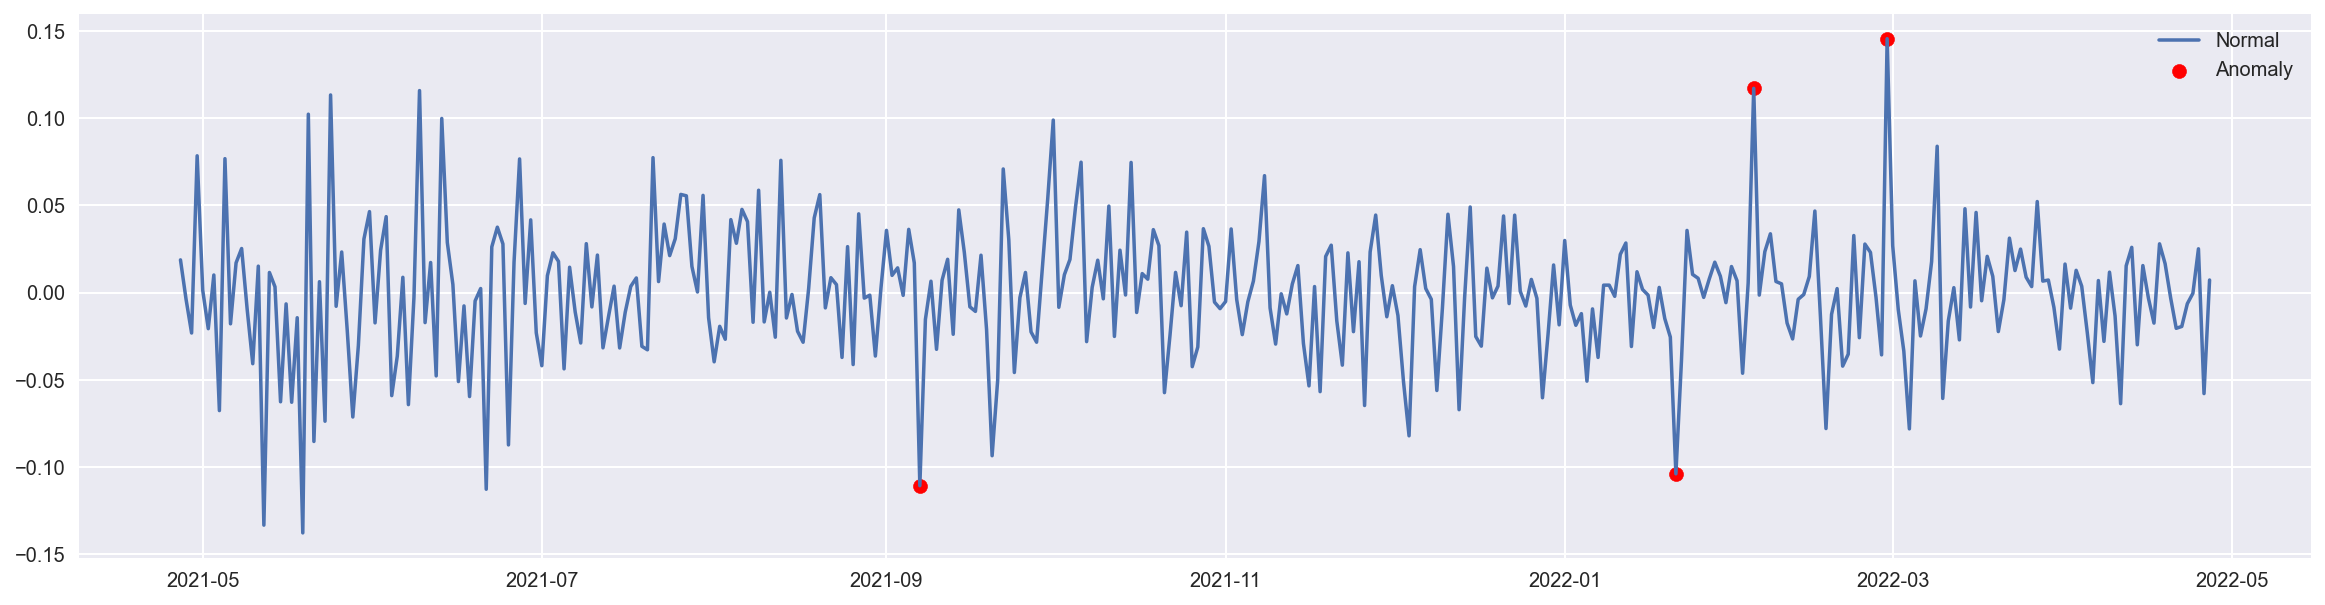

In [57]:
plt.style.use("seaborn")

plt.figure(figsize=(20,5))
plt.plot(btc_outliers.index,btc_outliers["simple return"],label="Normal")
plt.scatter(outliers.index,outliers["simple return"],color="r",label="Anomaly") # 放上異常值
plt.legend()